In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Forgetters
from Forgetters.GradientBoostingForgetters import GBClassifierForgetter, GBRegressorForgetter
from Forgetters.AdaptiveBoostingForgetters import ABClassifierForgetter, ABRegressorForgetter

# Compression strategies
from CompressionStrategies.DropUnforgettable import DropUnforgettableClassification
from CompressionStrategies.DropNForgets import DropNForgetsClassification

# sklearn stuff
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

# Other utils
from utils import predictions_to_y, get_accuracy_score
from DatasetLoader import DatasetLoader

In [14]:
import openml
from sklearn.preprocessing import LabelEncoder


# List datasets with specific criteria (e.g., classification with >2 classes)
datasets = openml.datasets.list_datasets(tag='OpenML100')
filtered_datasets = [
    ds for ds in datasets.values()
    if ds['NumberOfClasses'] == 2 and ds['NumberOfInstances'] < 1000 and  ds['NumberOfInstancesWithMissingValues'] == 0
]

# Display filtered dataset information
df = pd.DataFrame(filtered_datasets)

dataset = openml.datasets.get_dataset(int(1464))
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
enc = LabelEncoder()
y_n = enc.fit_transform(y)
y = pd.Series(y_n)

X = X.select_dtypes(include=['number'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [15]:
compression_strategy = DropNForgetsClassification(n=1, random_keeps=0.3)
base_model = DecisionTreeClassifier(max_depth=2)

In [16]:
lr = 10
n_estimators = 200
# test compression 
forg = ABClassifierForgetter(estimator=base_model, learning_rate=lr ,n_estimators=n_estimators)
X, y = forg.fit_transform(X_train, y_train, compression_strategy)


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(


In [17]:
# Get which points are removed
forg = ABClassifierForgetter(estimator=base_model, learning_rate=1 ,n_estimators=400)

forg.fit(X_train,y_train)
mask = forg.get_mask(compression_strategy)

compression_strategy.get_counts()

c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(


array([13,  0,  0,  2,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  1,  0,  7,  0,  0,  1,  0,
        1,  0,  0,  0,  1,  0,  5,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,
        4,  0,  5,  0,  0,  0,  0,  0,  1,  0,  0,  2,  0,  2,  0,  0,  4,
        0,  0,  0,  1,  1,  0,  0,  0,  0,  4,  0,  0,  3,  0,  1,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  4,  1,  0,  0,  0,  0,  0,  0, 13,  4,  2,  0,  0,  0,  0,
        0,  0,  2,  0,  4,  8,  0,  1,  1,  0,  6,  0,  6,  0,  0,  0,  0,
        0,  0,  0,  3,  0,  0,  0,  4,  0,  0,  0,  0,  1,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  2,  2,  1,  0,  2,  0,  0,  0,
        1,  1,  2,  0,  0, 18,  0,  0,  2,  6,  0,  0,  1,  0,  7,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  1

c:\Users\Antoine\Desktop\CIA\BoostingProject\display_utils.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pc1[kept_points], pc2[kept_points], c=y_colors[kept_points], cmap='coolwarm')
c:\Users\Antoine\Desktop\CIA\BoostingProject\display_utils.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pc1[removed_points], pc2[removed_points], facecolors='none', edgecolors=y_colors[removed_points], cmap='coolwarm')


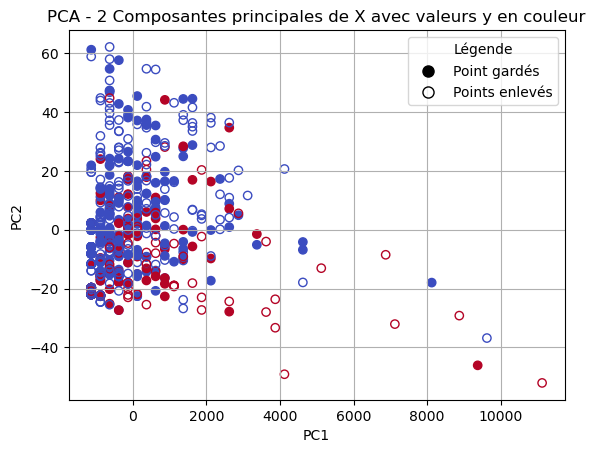

c:\Users\Antoine\Desktop\CIA\BoostingProject\display_utils.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pc1[kept_points], pc2[kept_points], c=y_colors[kept_points], cmap='coolwarm')


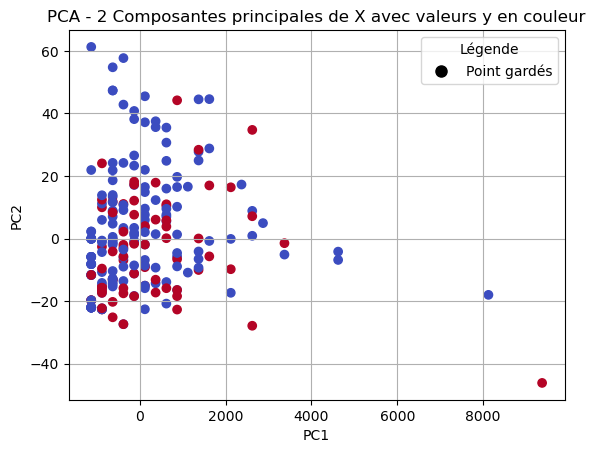

In [18]:
from display_utils import display_pca_and_labels, display_only_kept_points
display_pca_and_labels(X_train,y_train, mask)
display_only_kept_points(X_train,y_train, mask)

In [19]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

def get_baseline(predictive_model, X_train, y_train, X_test, y_test, score_function=accuracy_score, N_repeats=20, step=10):
    m = len(X_train)
    
    def get_score(X, y):
        predictive_model.fit(X, y)
        y_pred = predictive_model.predict(X_test)
        return score_function(y_test, y_pred)
    
    all_baselines = []
    for i in range(N_repeats):
        X_train_shuf, y_train_shuf = shuffle(X_train, y_train, random_state=i)
        
        accuracy_baseline = []
        for j in range(1, m, step):
            score = get_score(X_train_shuf[:j], y_train_shuf[:j])
            accuracy_baseline.append(score)
        all_baselines.append(accuracy_baseline)
        
    x = range(1, m, step)
    all_baselines = np.array(all_baselines)
    y = np.mean(all_baselines, axis=0)
    return x, y
    

In [20]:
def display_forgetter_curve(x_c_score, y_c_score, x, baseline):
    plt.plot(x_c_score, y_c_score, label="DropNForgetsClassification")
    plt.plot(x, baseline, label="Random compression")

    plt.legend()
    plt.xlabel("Nombre de points conservés")
    plt.ylabel("Score accuracy")
    plt.title("Accuracy test de RandomForestRegressor sur données compressées de SANG 😬")
    plt.grid()
    plt.show()  

In [23]:


def compute_baseline_and_forgetter_curve():
    # baseline 
    predictive_model = RandomForestClassifier(n_estimators=21, max_depth=3)
    x, baseline = get_baseline(predictive_model, X_train, y_train, X_test, y_test, N_repeats=5, step=10)
    
    random_keeps = [0, 0.05, 0.1, 0.2, 0.5]

    
    n_forgets = [1,2,5]
    learning_rate = [0.1, 1, 2, 10]
    
    # selectively compressed data
    
    def get_score(X, y):
        predictive_model.fit(X, y)
        y_pred = predictive_model.predict(X_test)
        return balanced_accuracy_score(y_test, y_pred)
            
    for rk in random_keeps:
        for lr in learning_rate:
            
            print(f"Performance for rk = {rk} and lr = {lr}")
            
            base_model = DecisionTreeClassifier(max_depth=2)
            comp_model = ABClassifierForgetter(estimator=base_model, learning_rate=lr, n_estimators=400)
            comp_model.fit(X_train, y_train)
            
            # n doesn't matter here as we later loop over all ns to generate graph
            compression_strategy = DropNForgetsClassification(n=1)
            _ = comp_model.transform(X_train, compression_strategy)
            counts = compression_strategy.get_counts()
            
            x_c_score = []
            y_c_score = []
            
            for nf in range(max(counts)):
                    comp = DropNForgetsClassification(n=nf, random_keeps=rk)
                    mask = comp.get_compression_mask(comp_model.predictions_over_time, y_train)
                    X_comp = X_train[mask]
                    y_comp = y_train[mask]

                    x_c_score.append(len(y_comp))       
                    y_c_score.append(get_score(X_comp, y_comp))
        
            display_forgetter_curve(x_c_score, y_c_score, x, baseline)
            
            #display_pca_and_labels(X_train,y_train, mask)
            #display_only_kept_points(X_train,y_train, mask)
            
            
    
    

Performance for rk = 0 and lr = 0.1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


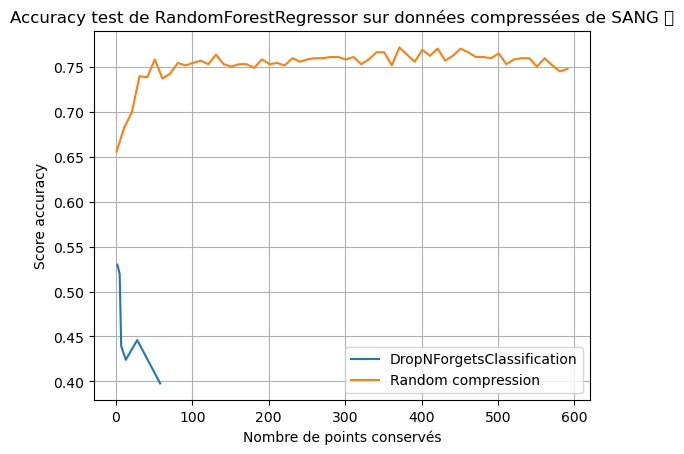

Performance for rk = 0 and lr = 1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


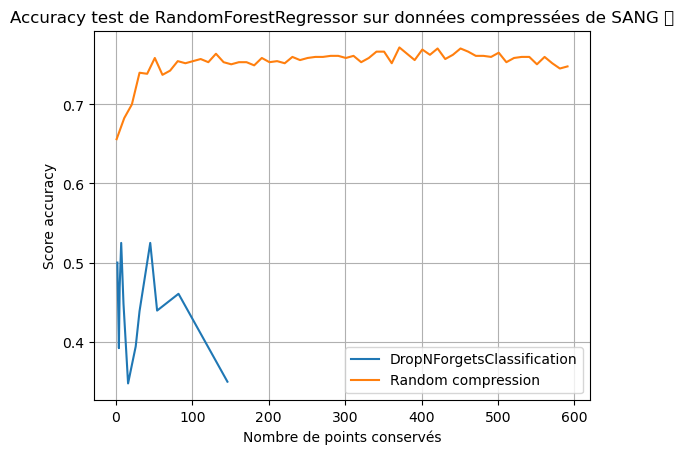

Performance for rk = 0 and lr = 2


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


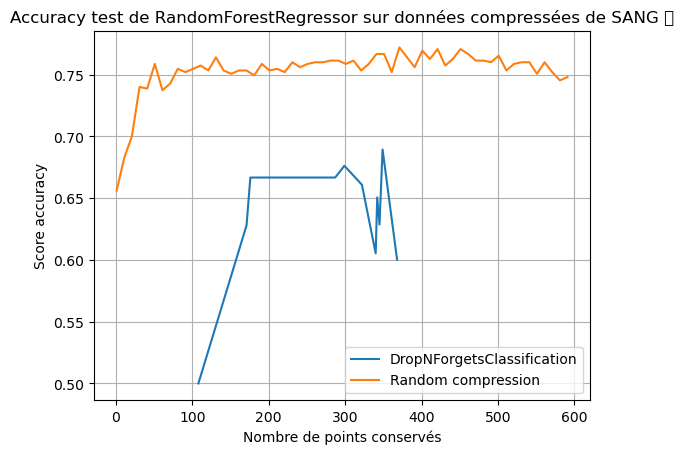

Performance for rk = 0 and lr = 10


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


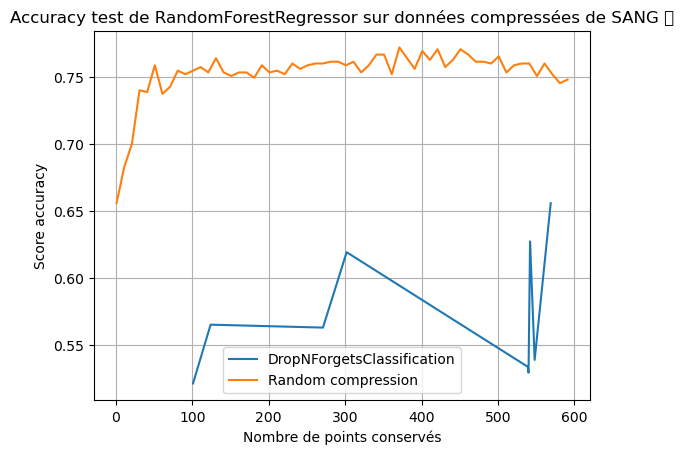

Performance for rk = 0.05 and lr = 0.1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


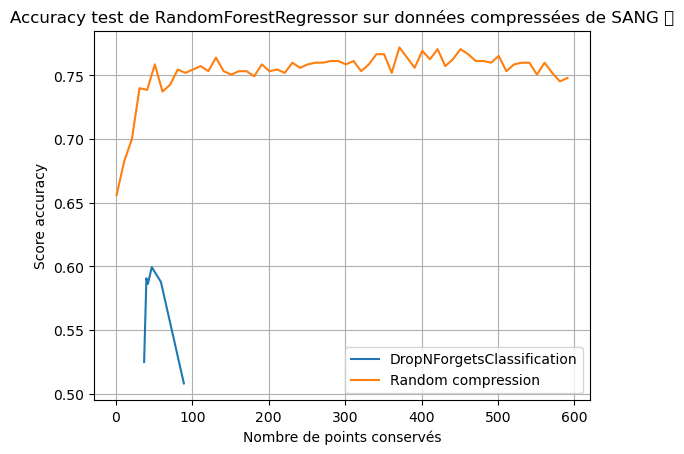

Performance for rk = 0.05 and lr = 1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


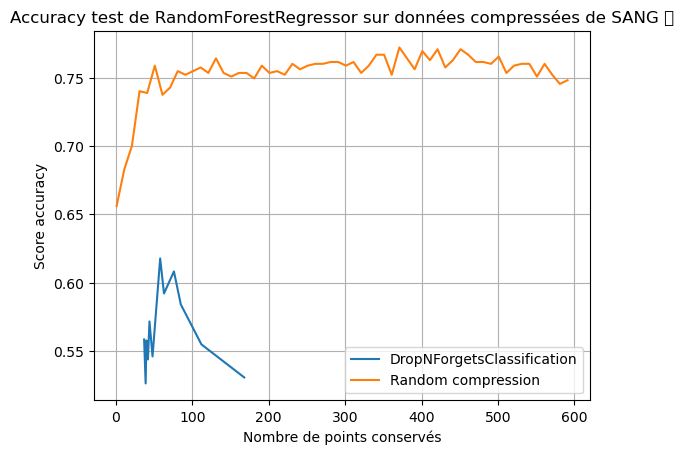

Performance for rk = 0.05 and lr = 2


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


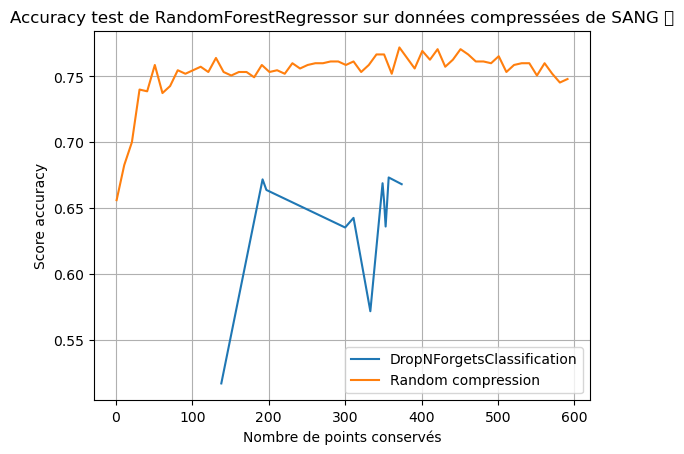

Performance for rk = 0.05 and lr = 10


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


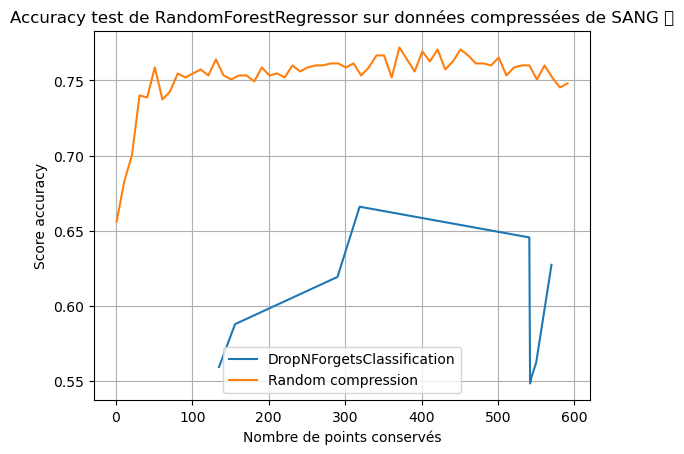

Performance for rk = 0.1 and lr = 0.1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


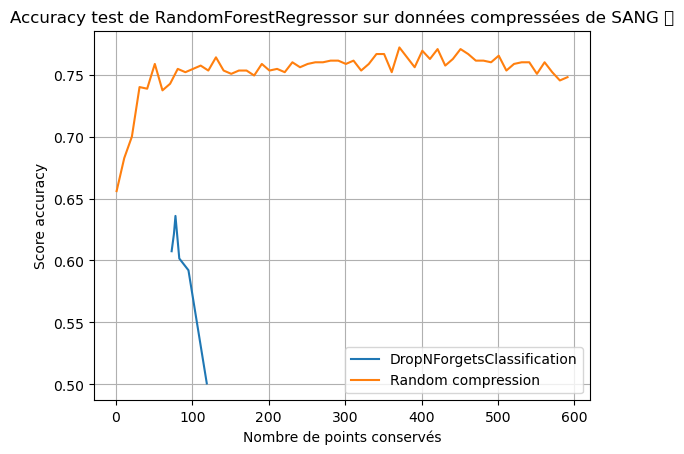

Performance for rk = 0.1 and lr = 1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


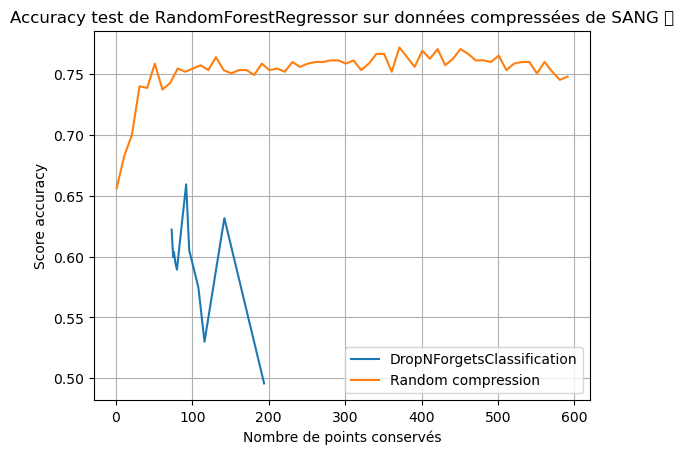

Performance for rk = 0.1 and lr = 2


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


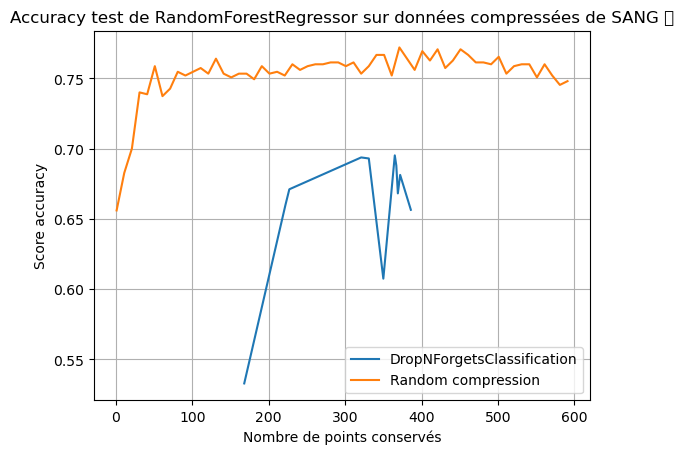

Performance for rk = 0.1 and lr = 10


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


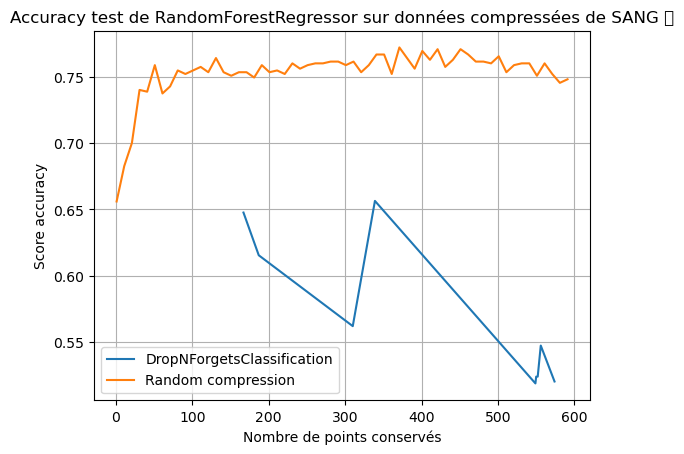

Performance for rk = 0.2 and lr = 0.1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


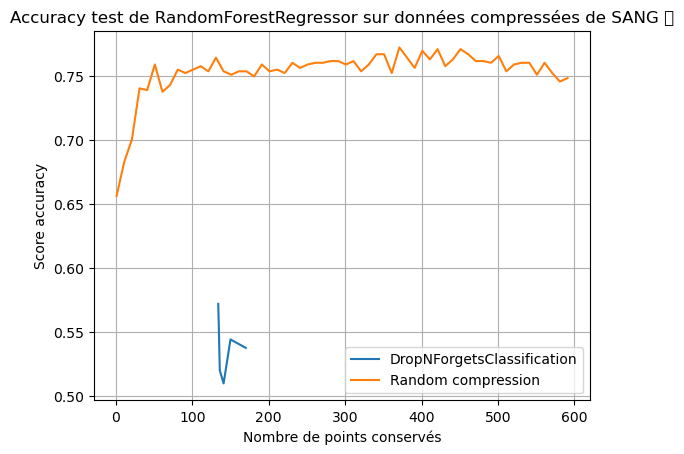

Performance for rk = 0.2 and lr = 1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


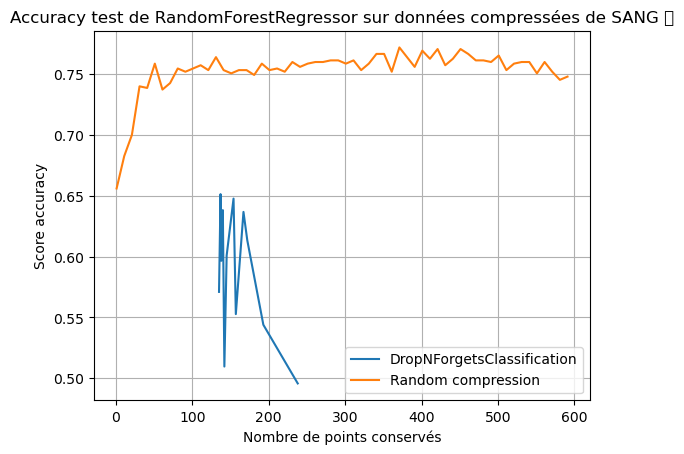

Performance for rk = 0.2 and lr = 2


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


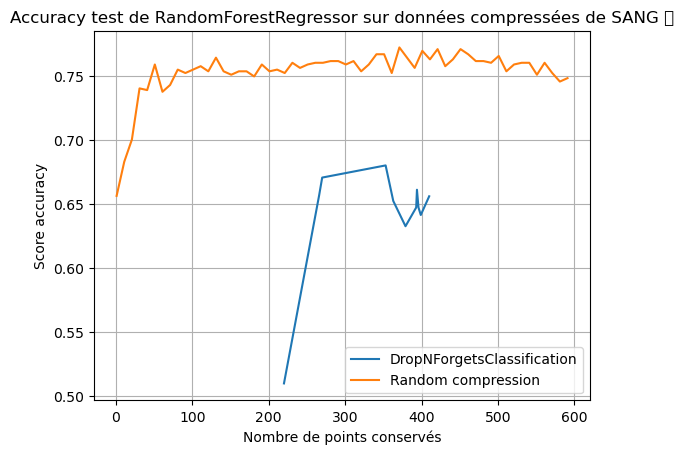

Performance for rk = 0.2 and lr = 10


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


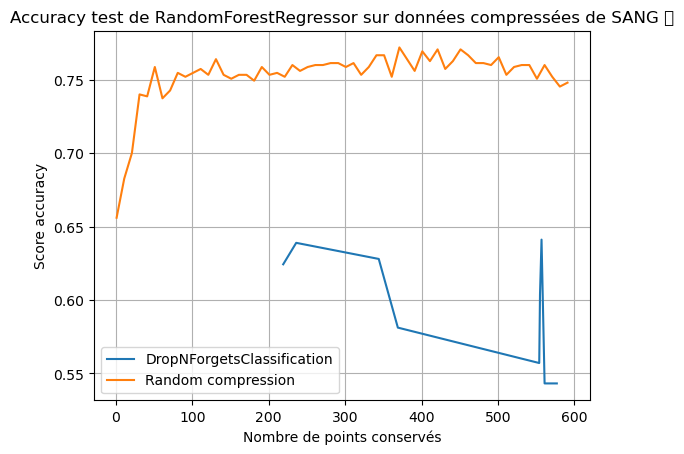

Performance for rk = 0.5 and lr = 0.1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


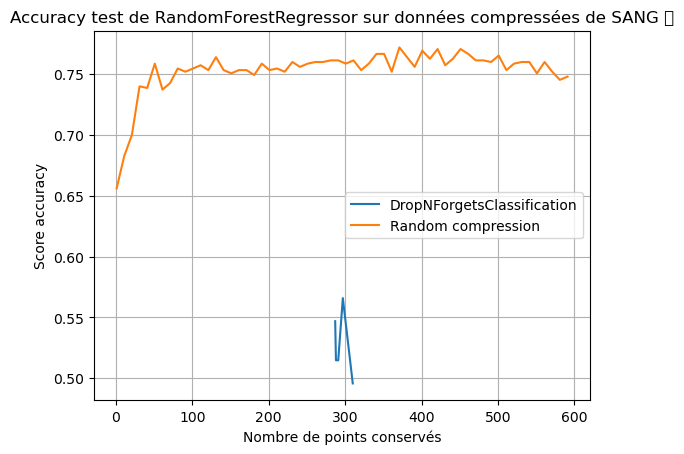

Performance for rk = 0.5 and lr = 1


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


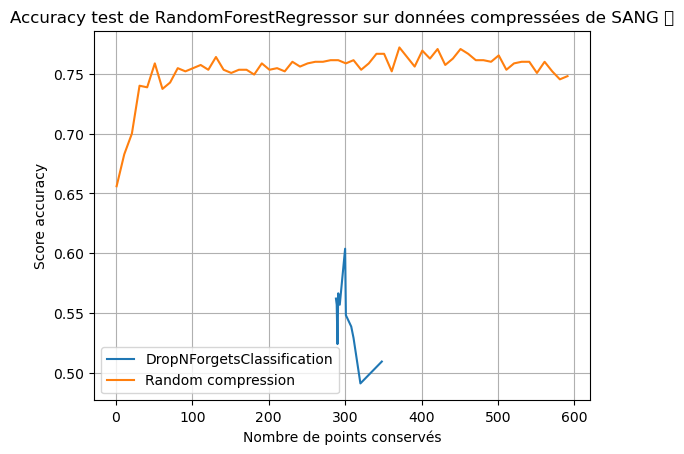

Performance for rk = 0.5 and lr = 2


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


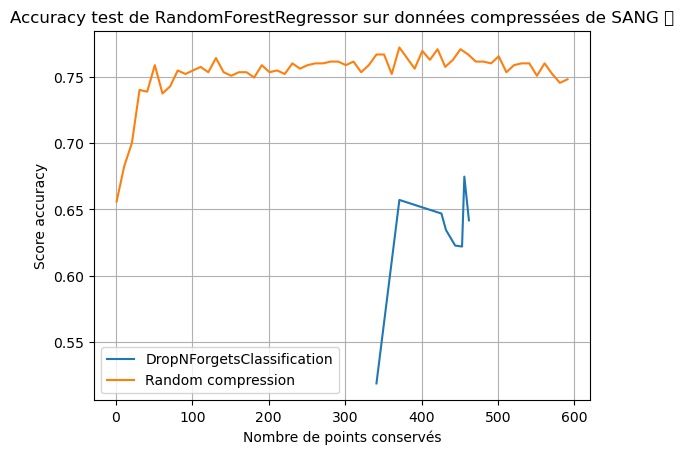

Performance for rk = 0.5 and lr = 10


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ABClassifierForgetter was fitted with feature names
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


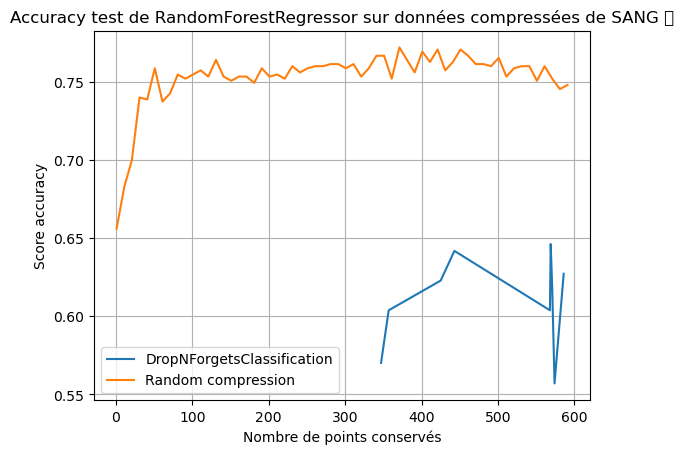

In [24]:
compute_baseline_and_forgetter_curve()